# Processing EEG Data

This notebook runs through pre-processing and parameterizing power spectra on EEG data.

It can be used to step through processing for individual subjects. 

Note that this notebook isn't used to process the full group. For this, `process_eeg.py` from the `scripts` folder should be used.

In [1]:
%matplotlib inline

import os
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from scipy.signal import periodogram

# MNE & associated code
import mne
from mne.preprocessing import ICA, read_ica
from mne.utils import _time_mask

from autoreject import AutoReject, read_auto_reject
from autoreject.autoreject import _apply_interp

# FOOOF, and custom helper & utility functions
from fooof import FOOOF, FOOOFGroup
from fooof.objs import average_fg
from fooof.plts import plot_spectrum
from fooof.utils import trim_spectrum
from fooof.data import FOOOFSettings
from fooof.analysis import get_band_peak_fm, get_band_peak_fg

## Settings

In [2]:
# Import custom code for this analysis
import sys
sys.path.append('../code')

from settings import DATA_PATH, RESULTS_PATH, BANDS

In [3]:
# Set subject index to load (as index from subjs_files)
sub_ind = 23

In [4]:
# Preprocessing options
#   If these are false - loads & applies saved solutions
run_ica = False
run_auto_reject = False

# Set to run analysis across all channels
all_channels = True

In [5]:
# Set which average function to use
avg_func = np.mean
#avg_func = np.median

In [6]:
# Wether to save out plots or not
SAVE_FIG = False

## Data Loading

In [7]:
# Get list of subject files
subj_files = os.listdir(DATA_PATH)
subj_files = [file for file in subj_files if 'bdf' in file.lower()]
subj_files = sorted(subj_files)

In [8]:
# Get & check which subject is being run
subj_file = subj_files[sub_ind]
subj_label = subj_file.split('.')[0]

print(subj_label)

YA_042107-2_RAW


In [9]:
# Load data, and do things for fixing up the channel labels & types
eeg_data = mne.io.read_raw_bdf(os.path.join(DATA_PATH, subj_file), preload=True)

# Fix channel name labels
eeg_data.info['ch_names'] = [chl[2:] for chl in eeg_data.ch_names[:-1]] + \
    [eeg_data.ch_names[-1]]
for ind, chi in enumerate(eeg_data.info['chs']):
    eeg_data.info['chs'][ind]['ch_name'] = eeg_data.info['ch_names'][ind]

# Set channel types
ch_types = {'LHor' : 'eog', 'RHor' : 'eog',
            'IVer' : 'eog', 'SVer' : 'eog',
            'LMas' : 'misc', 'RMas' : 'misc',
            'Nose' : 'misc', 'EXG8' : 'misc'}
eog_chs = ['LHor', 'RHor', 'IVer', 'SVer']

# Set channel types
eeg_data.set_channel_types(ch_types);

Extracting EDF parameters from /Users/tom/Documents/Data/02-Shared/Voytek_WMData/G2/YA_042107-2_RAW.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1396223  =      0.000 ...  2726.998 secs...


In [10]:
# Set reference
eeg_data = eeg_data.set_eeg_reference(ref_channels='average',
                                      projection=False, verbose=False)

In [11]:
# Get sampling rate
srate = int(eeg_data.info['sfreq'])
print(srate)

512


In [14]:
# Check if there are any channels marked bad
eeg_data.info['bads']

[]

### Montage

In [12]:
# Set channel montage
chs = mne.channels.make_standard_montage('standard_1020')
eeg_data.set_montage(chs, verbose=False);

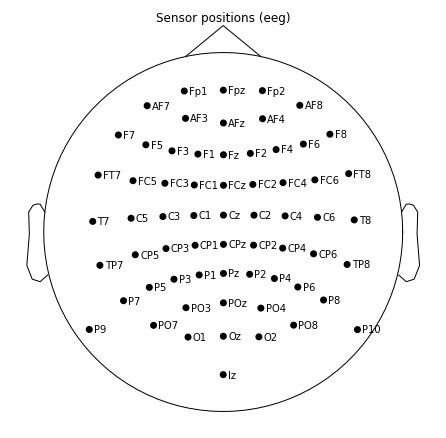

In [13]:
# Check channel positions
eeg_data.plot_sensors(show_names=True);

In [14]:
# Define channel clusters
le_chs = ['P3', 'P5', 'P7', 'P9', 'O1', 'PO3', 'PO7']
ri_chs = ['P4', 'P6', 'P8', 'P10', 'O2', 'PO4', 'PO8']
le_picks = mne.pick_channels(eeg_data.ch_names, le_chs)
ri_picks = mne.pick_channels(eeg_data.ch_names, ri_chs)

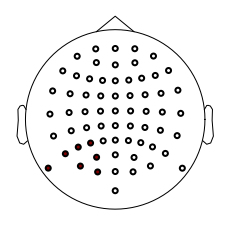

In [15]:
# Check channel positions
fig, ax = plt.subplots(figsize=[3, 3])
fig = eeg_data.plot_sensors(show_names=False, title='',
                           ch_groups=[[], le_picks], axes=ax);

if SAVE_FIG:
    plt.savefig('../figures/EEGHead.pdf')

### Pre-Processing: ICA

ICA is used to remove eye-related artifact. 

To do so, we do ICA on the data, and then use an MNE function that identifies ICA components to reject based on correlation with EOG channels. 

In [16]:
# High-pass filter for ICA
eeg_data.filter(l_freq=1., h_freq=None, fir_design='firwin');

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1691 samples (3.303 sec)



In [17]:
if run_ica:
    
    # ICA settings
    method = 'fastica'

    n_components = 0.99
    random_state = 48
    decim = None
    reject = {'eeg': 20e-4}

    # Initialize ICA object
    ica = ICA(n_components=n_components, method=method, random_state=random_state)
    
    # Fit ICA
    ica.fit(eeg_data, decim=decim, reject=reject)

else:
    ica = read_ica(os.path.join(RESULTS_PATH, 'ICA', subj_label + '-ica.fif'))

Reading ../data/ICA/YA_042107-2_RAW-ica.fif ...
Now restoring ICA solution ...
Ready.


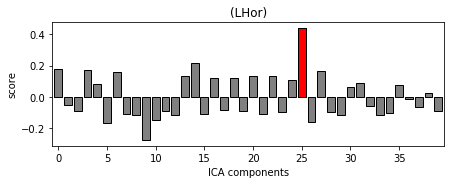

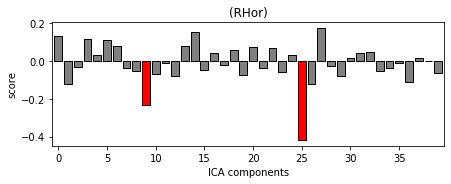

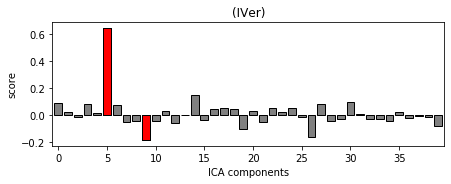

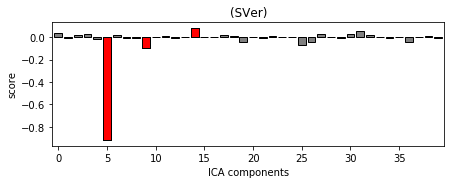

In [18]:
# Find components to drop, based on correlation with EOG channels
drop_inds = []
for chi in eog_chs:
    inds, scores = ica.find_bads_eog(eeg_data, ch_name=chi, threshold=2.5,
                                     l_freq=1, h_freq=10, verbose=False)
    drop_inds.extend(inds)
    ica.plot_scores(scores, exclude=inds, labels=chi);
    
drop_inds = list(set(drop_inds))

In [19]:
# Check the set of components to be dropped
ica.exclude = drop_inds

print('Number of component to drop: \t', len(ica.exclude))
print('Dropped component indices: \t', ica.exclude)

Number of component to drop: 	 4
Dropped component indices: 	 [25, 5, 9, 14]


In [20]:
# # Save out the ICA solution
# ica.save('test-ica.fif')

# # Note: can later load ICAs:
# from mne.preprocessing import read_ica
# ica = read_ica(ica_file)

In [21]:
# Visualize the ICA components
#ica.plot_components();

In [22]:
# Check description of the components that are marked to be dropped
#ica.plot_properties(eeg_data, picks=drop_inds);

Transforming to ICA space (40 components)
Zeroing out 4 ICA components


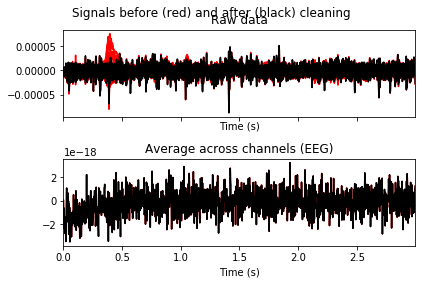

In [23]:
# Check the overlay of the data, with the components to be rejected
ica.plot_overlay(eeg_data, exclude=drop_inds);

In [24]:
# Apply ICA to data
eeg_data = ica.apply(eeg_data);

Transforming to ICA space (40 components)
Zeroing out 4 ICA components


## Event management

In [25]:
# Get event information
evs = mne.find_events(eeg_data, shortest_event=1, verbose=False)

# Check all used event codes
ev_codes = np.unique(evs[:, 2])

In [26]:
# Set up event code dictionary, with key labels for each event type
ev_dict = {'LeLo1': [201, 202], 'LeLo2': [205, 206], 'LeLo3': [209, 210], 
           'RiLo1': [203, 204], 'RiLo2': [207, 208], 'RiLo3': [211, 212]}

# Event codes for correct and incorrect codes
corr_codes = [2, 1]
inco_codes = [102, 101]

In [27]:
# Extract a list of all the event labels
all_trials = [it for it2 in ev_dict.values() for it in it2]

# Create list of new event codes to be used to label correct trials (300s)
all_trials_new = [it + 100 for it in all_trials]
# This is an annoying way to collapse across the doubled event markers from above
all_trials_new = [it - 1 if not ind % 2 == 0 else it \
                  for ind, it in enumerate(all_trials_new)]
# Get labelled dictionary of new event names
ev_dict2 = {k : v for k, v in zip(ev_dict.keys(), set(all_trials_new))}

In [28]:
# Initialize variables to store new event definitions
evs2 = np.empty(shape=[0, 3], dtype='int64')
lags = np.array([])

# Loop through, creating new events for all correct trials
t_min, t_max = -0.4, 3.0
for ref_id, targ_id, new_id in zip(all_trials, corr_codes * 6, all_trials_new):
    
    t_evs, t_lags = mne.event.define_target_events(\
        evs, ref_id, targ_id, srate, t_min, t_max, new_id)
    
    if len(t_evs) > 0:
        evs2 = np.vstack([evs2, t_evs])
        lags = np.concatenate([lags, t_lags])
        
# Sort event codes
evs2 = np.sort(evs2, 0)

In [29]:
# Check how many of each event type there are
print(Counter(evs[:, 2]))
print('\n')
print(Counter(evs2[:, 2]))

Counter({55: 800, 1: 388, 2: 387, 205: 50, 212: 50, 211: 50, 201: 50, 210: 50, 204: 50, 203: 50, 213: 50, 216: 50, 208: 50, 214: 50, 202: 50, 207: 50, 206: 50, 209: 50, 215: 50, 101: 14, 102: 10, 65536: 9})


Counter({303: 100, 301: 99, 305: 99, 309: 98, 311: 95, 307: 94})


### Check Data

In [30]:
# Set channel of interest
ch_ind = eeg_data.ch_names.index('Oz')

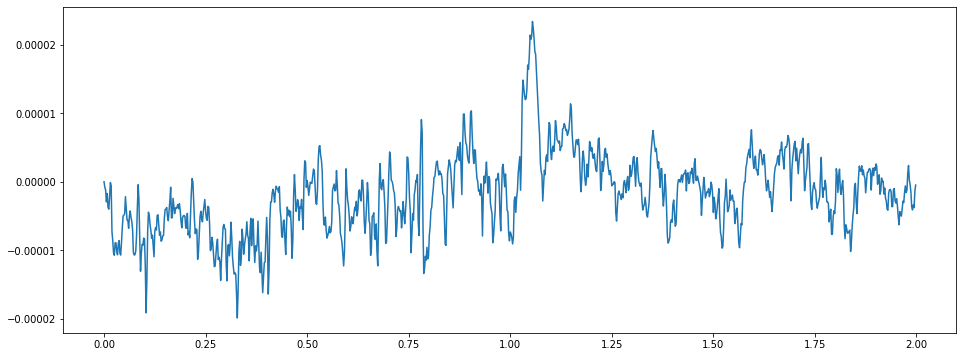

In [31]:
# Plot a segment of data - to eyeball
start = 0 # Index to start plotting at, in samples
inds = [start, start + 2*srate]  # 2 seconds of data
fig = plt.figure(figsize=[16, 6])
plt.plot(eeg_data.times[inds[0]:inds[1]],
         eeg_data._data[ch_ind, inds[0]:inds[1]])

In [32]:
# PSD settings
n_fft, n_overlap, n_per_seg = int(2*srate), int(srate), int(2*srate)

# Data settings
fmin, fmax = (1, 50)
tmin, tmax = (5, 125)

# Calculate PSDs (across all channels) - from the first 2 minute of data
psds, freqs = mne.time_frequency.psd_welch(
    eeg_data, fmin=fmin, fmax=fmax, tmin=tmin ,tmax=tmax,
    n_fft=n_fft, n_overlap=n_overlap, n_per_seg=n_per_seg, verbose=False)

### Individualized Alpha Peak

In [33]:
# Get individual power spectrum of interest
cur_psd = psds[ch_ind, :]

In [34]:
# Get the peak within the alpha range
al_freqs, al_psd = trim_spectrum(freqs, cur_psd, [7, 14])
icf_ind = np.argmax(al_psd)
al_icf = al_freqs[icf_ind]

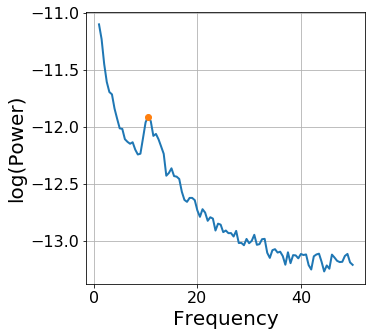

In [35]:
# Plot the power spectrum, with the individually detected alpha peak
plot_spectrum(freqs, cur_psd, log_powers=True, ax=plt.subplots(figsize=(5, 5))[1])
plt.plot(al_icf, np.log10(al_psd[icf_ind]), '.', markersize=12)

### FOOOF 

In [36]:
# Initialize FOOOFGroup object
f_range = [3, 25]
fg = FOOOFGroup(peak_width_limits=[1, 6], max_n_peaks=6,
                min_peak_height=0.05, peak_threshold=1.5)

In [37]:
# Run FOOOF across all power spectra
fg.fit(freqs, psds, f_range, progress='tqdm.notebook')

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 25 Hz                        
                                 Frequency Resolution is 0.50 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -11.0592, 1.2919                                         
                                                                                                  
                                       5 peaks were found:                                        
          

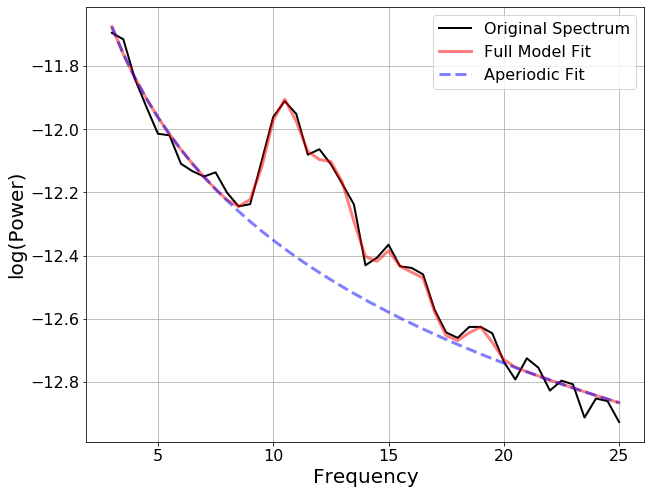

In [38]:
# Check FOOOF model fit of particular channel of interest
fm = fg.get_fooof(ch_ind, True)
fm.print_results()
fm.plot()

In [39]:
# Extract individualized CF from channel Oz
fooof_freq, _, fooof_bw = get_band_peak_fm(fm, BANDS.alpha)

# If not FOOOF alpha extracted, reset to 10
if np.isnan(fooof_freq):
    fooof_freq = 10

In [40]:
# Compare peak-find alpha peak to fooof alpha peak
print('IndiPeak CF: \t{:0.2f}'.format(al_icf))
print('FOOOF    CF: \t{:0.2f}'.format(fooof_freq))

IndiPeak CF: 	10.50
FOOOF    CF: 	10.44


In [41]:
# Check extracted FOOOF alpha properties
print('Alpha CF: \t{:0.2f}'.format(fooof_freq))
print('Alpha BW: \t{:0.2f}'.format(fooof_bw))

Alpha CF: 	10.44
Alpha BW: 	1.50


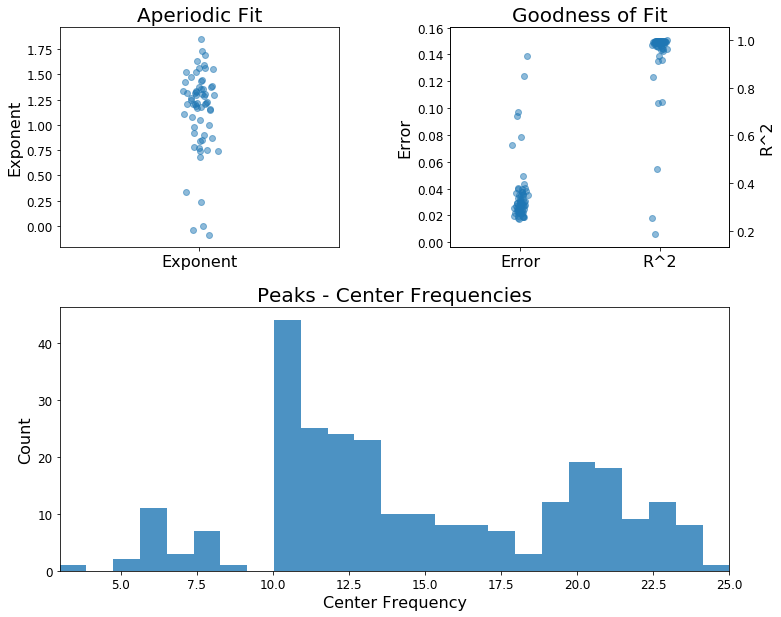

In [42]:
# Check a summary of the FOOOFGroup results across all channels
fg.plot()

In [43]:
# Extract some FOOOF data across all electrodes

# Extract exponents - all channels
all_exps = fg.get_params('aperiodic_params', 'exponent')

# Extract alpha oscillations - all channels
alphas = get_band_peak_fg(fg, BANDS.alpha)

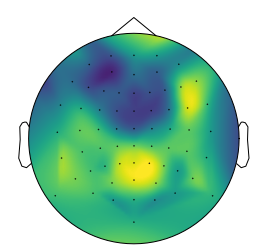

In [44]:
# Plot alpha topography
data_ind = 1 # 0:CF; 1:PW; 2:BW

# For sake of visualization, replace any NaN with the mean
temp_data = alphas[:, data_ind]
inds = np.where(np.isnan(temp_data))
temp_data[inds] = np.nanmean(temp_data)

mne.viz.plot_topomap(temp_data, eeg_data.info, cmap=cm.viridis, contours=0);

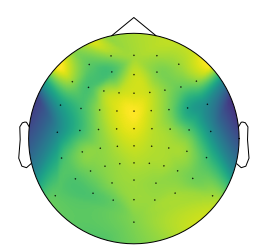

In [45]:
# Plot exponent topography
mne.viz.plot_topomap(all_exps, eeg_data.info, cmap=cm.viridis, contours=0);

## Filtering & Envelope

#### Canonical Alpha Range

In [46]:
# Filter data to canonical alpha band: 8-12 Hz
alpha_data = eeg_data.copy()
alpha_data.filter(8, 12, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 sec)



<RawEDF | YA_042107-2_RAW.bdf, 73 x 1396224 (2727.0 s), ~777.8 MB, data loaded>

#### FOOOF defined subject-specific alpha band

In [47]:
# Filter data to FOOOF derived alpha band
fooof_data = eeg_data.copy()
fooof_data.filter(fooof_freq-2, fooof_freq+2, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8.4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.44
- Lower transition bandwidth: 2.11 Hz (-6 dB cutoff frequency: 7.39 Hz)
- Upper passband edge: 12.44 Hz
- Upper transition bandwidth: 3.11 Hz (-6 dB cutoff frequency: 14.00 Hz)
- Filter length: 801 samples (1.564 sec)



<RawEDF | YA_042107-2_RAW.bdf, 73 x 1396224 (2727.0 s), ~777.8 MB, data loaded>

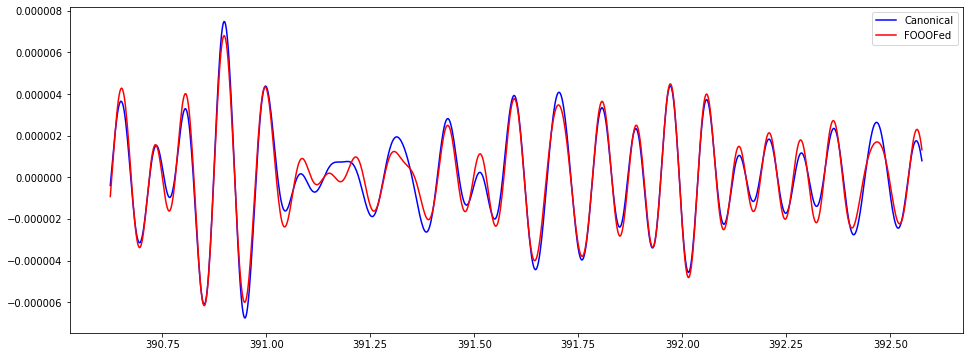

In [48]:
# Plot the differently filtered traces - check for differences
inds = [200000, 201000] # Arbitrary time points
fig = plt.figure(figsize=[16, 6])
plt.plot(alpha_data.times[inds[0]:inds[1]],
         alpha_data._data[ch_ind, inds[0]:inds[1]],
         'b', label='Canonical')
plt.plot(fooof_data.times[inds[0]:inds[1]],
         fooof_data._data[ch_ind, inds[0]:inds[1]],
         'r', label='FOOOFed')
plt.legend()

In [49]:
# Take the analytic amplitude (hilbert) of the alpha-filtered signals
alpha_data.apply_hilbert(envelope=True)
fooof_data.apply_hilbert(envelope=True)

<RawEDF | YA_042107-2_RAW.bdf, 73 x 1396224 (2727.0 s), ~777.8 MB, data loaded>

### Epoching

In [50]:
# Epoch settings
tmin, tmax = -0.85, 1.1

# Epoch trials - raw data for trial rejection
epochs = mne.Epochs(eeg_data, evs2, ev_dict2,
                    tmin=tmin, tmax=tmax,
                    baseline=None, preload=True)

# Epoch trials - filtered version
epochs_alpha = mne.Epochs(alpha_data, evs2, ev_dict2,
                          tmin=tmin, tmax=tmax,
                          baseline=(-0.50, -0.35), preload=True);
epochs_fooof = mne.Epochs(fooof_data, evs2, ev_dict2,
                          tmin=tmin, tmax=tmax,
                          baseline=(-0.50, -0.35), preload=True);

585 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 585 events and 999 original time points ...
0 bad epochs dropped
585 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 585 events and 999 original time points ...
0 bad epochs dropped
585 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 585 events and 999 original time points ...
0 bad epochs dropped


### Pre-Processing: Autoreject

In [51]:
if run_auto_reject:
    
    # Initialize & fit autoreject
    ar = AutoReject(n_jobs=4, verbose=False)
    ar.fit(epochs)

else:
    ar = read_auto_reject(os.path.join(RESULTS_PATH, 'AR', subj_label + '-ar.hdf5'))
    ar.verbose = 'tqdm_notebook'

In [52]:
# # Save out the autoreject solution
# ar_file = 'test-ar.hdf5'
# ar.save(ar_file, overwrite=True)

# # Note: can later load ARs
# from autoreject import read_auto_reject
# ar = read_auto_reject(ar_file)

In [53]:
# Apply autoreject to the original epochs object it was learnt on
epochs, rej_log = ar.transform(epochs, return_log=True)


No bad epochs were found for your data. Returning a copy of the data you wanted to clean. Interpolation may have been done.


In [54]:
# Apply autoreject to the copies of the data - apply interpolation, then drop same epochs
_apply_interp(rej_log, epochs_alpha, ar.threshes_, ar.picks_, ar.dots, ar.verbose)
epochs_alpha.drop(rej_log.bad_epochs);
_apply_interp(rej_log, epochs_fooof, ar.threshes_, ar.picks_, ar.dots, ar.verbose)
epochs_fooof.drop(rej_log.bad_epochs);


Dropped 0 epochs: 



Dropped 0 epochs: 


In [55]:
# Check which epochs were dropped
drop_inds = np.where(rej_log.bad_epochs)[0]
print(drop_inds)

[]


### Set channel clusters

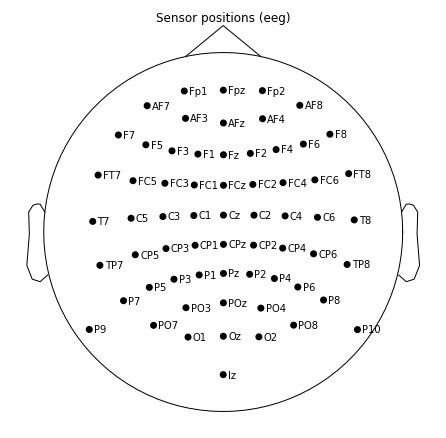

In [56]:
# Replot channel positions
eeg_data.plot_sensors(show_names=True);

In [57]:
# Set channel clusters for analysis
#   Take channels contralateral to stimulus presentation
le_chs = ['P3', 'P5', 'P7', 'P9', 'O1', 'PO3', 'PO7']
le_inds = [epochs.ch_names.index(chn) for chn in le_chs]
ri_chs = ['P4', 'P6', 'P8', 'P10', 'O2', 'PO4', 'PO8']
ri_inds = [epochs.ch_names.index(chn) for chn in ri_chs]

### Trial-Related Analysis

In [58]:
# Pull out channel of interest for each load level - canonical data
#  Channels extracted are those contralateral to stimulus presentation
lo1_a = np.concatenate([epochs_alpha['LeLo1']._data[:, ri_inds, :],
                        epochs_alpha['RiLo1']._data[:, le_inds, :]], 0)
lo2_a = np.concatenate([epochs_alpha['LeLo2']._data[:, ri_inds, :],
                        epochs_alpha['RiLo2']._data[:, le_inds, :]], 0)
lo3_a = np.concatenate([epochs_alpha['LeLo3']._data[:, ri_inds, :],
                        epochs_alpha['RiLo3']._data[:, le_inds, :]], 0)

In [59]:
# Pull out channel of interest for each load level - fooofed data
#  Channels extracted are those contralateral to stimulus presentation
lo1_f = np.concatenate([epochs_fooof['LeLo1']._data[:, ri_inds, :],
                        epochs_fooof['RiLo1']._data[:, le_inds, :]], 0)
lo2_f = np.concatenate([epochs_fooof['LeLo2']._data[:, ri_inds, :],
                        epochs_fooof['RiLo2']._data[:, le_inds, :]], 0)
lo3_f = np.concatenate([epochs_fooof['LeLo3']._data[:, ri_inds, :],
                        epochs_fooof['RiLo3']._data[:, le_inds, :]], 0)

In [60]:
# Calculate average across trials and channels
lo1_a_avg = np.mean(lo1_a, 1).mean(0)
lo2_a_avg = np.mean(lo2_a, 1).mean(0)
lo3_a_avg = np.mean(lo3_a, 1).mean(0)
canonical_avg = np.vstack([lo1_a_avg, lo2_a_avg, lo3_a_avg])

# Calculate average across trials and channels
lo1_f_avg = np.mean(lo1_f, 1).mean(0)
lo2_f_avg = np.mean(lo2_f, 1).mean(0)
lo3_f_avg = np.mean(lo3_f, 1).mean(0)
fooofed_avg = np.vstack([lo1_f_avg, lo2_f_avg, lo3_f_avg])

## FOOOFING TRIAL AVERAGED DATA

In [61]:
# Set labels
load_labels = ['Load1', 'Load2', 'Load3']
side_labels = ['Contra', 'Ipsi']
seg_labels = ['Pre', 'Early', 'Late']

# Set up the dictionary to store all the FOOOF results
fm_dict = dict()
for load_label in load_labels:
    fm_dict[load_label] = dict()
    for side_label in side_labels:
        fm_dict[load_label][side_label] = dict()
        for seg_label in seg_labels:
            fm_dict[load_label][side_label][seg_label] = []

In [62]:
# Eyeball fm_dict works
fm_dict

{'Load1': {'Contra': {'Pre': [], 'Early': [], 'Late': []},
  'Ipsi': {'Pre': [], 'Early': [], 'Late': []}},
 'Load2': {'Contra': {'Pre': [], 'Early': [], 'Late': []},
  'Ipsi': {'Pre': [], 'Early': [], 'Late': []}},
 'Load3': {'Contra': {'Pre': [], 'Early': [], 'Late': []},
  'Ipsi': {'Pre': [], 'Early': [], 'Late': []}}}

In [63]:
# Settings for trial averaged FOOOFing
fmin, fmax = 3, 25
n_fft, n_overlap, n_per_seg = 4*srate, srate/4, srate
seg_times = [(-0.85, -0.35), (0.1, 0.6), (0.5, 1.0)]

In [64]:
# Initialize FOOOF objects
fooof_settings = FOOOFSettings(peak_width_limits=[1, 6], max_n_peaks=6,
                               min_peak_height=0.05, peak_threshold=1.5,
                               aperiodic_mode='fixed')
fm = FOOOF(*fooof_settings, verbose=False)
fg = FOOOFGroup(*fooof_settings, verbose=False)

In [65]:
# Loop through loads
for seg_label, seg_time in zip(seg_labels, seg_times):
    tmin, tmax = seg_time[0], seg_time[1]

    for le_label, ri_label, load_label in zip(['LeLo1', 'LeLo2', 'LeLo3'],
                                              ['RiLo1', 'RiLo2', 'RiLo3'], 
                                              load_labels):
        
        ## Calculate trial wise PSDs for left & right side trials
        # Note: psds arrays have shape [n_trials , n_channels, n_freqs]
        trial_freqs, le_trial_psds = periodogram(
            epochs[le_label]._data[:, :, _time_mask(epochs.times, tmin, tmax, srate)],
            srate, window='hann', nfft=4*srate)
        trial_freqs, ri_trial_psds = periodogram(
            epochs[ri_label]._data[:, :, _time_mask(epochs.times, tmin, tmax, srate)],
            srate, window='hann', nfft=4*srate)
        
        ## FIT ALL CHANNELS VERSION
        if all_channels:
    
            ## Average spectra across trials within a given load & side
            le_avg_psd_contra = avg_func(le_trial_psds[:, ri_inds, :], 0)
            le_avg_psd_ipsi = avg_func(le_trial_psds[:, le_inds, :], 0)
            ri_avg_psd_contra = avg_func(ri_trial_psds[:, le_inds, :], 0)
            ri_avg_psd_ipsi = avg_func(ri_trial_psds[:, ri_inds, :], 0)

            ## Combine spectra across left & right trials for given load
            ch_psd_contra = np.vstack([le_avg_psd_contra, ri_avg_psd_contra])
            ch_psd_ipsi = np.vstack([le_avg_psd_ipsi, ri_avg_psd_ipsi])

            ## Fit FOOOFGroup to all channels, average & and collect results
            fg.fit(trial_freqs, ch_psd_contra, [fmin, fmax])
            fm = average_fg(fg, BANDS)
            fm_dict[load_label]['Contra'][seg_label] = fm.copy()
            fg.fit(trial_freqs, ch_psd_ipsi, [fmin, fmax])
            fm = average_fg(fg, BANDS)
            fm_dict[load_label]['Ipsi'][seg_label] = fm.copy()
        
        ## COLLAPSE ACROSS CHANNELS VERSION 
        else:
        
            ## Average spectra across trials and channels within a given load & side
            le_avg_psd_contra = avg_func(avg_func(le_trial_psds[:, ri_inds, :], 0), 0)
            le_avg_psd_ipsi = avg_func(avg_func(le_trial_psds[:, le_inds, :], 0), 0)
            ri_avg_psd_contra = avg_func(avg_func(ri_trial_psds[:, le_inds, :], 0), 0)
            ri_avg_psd_ipsi = avg_func(avg_func(ri_trial_psds[:, ri_inds, :], 0), 0)

            ## Collapse spectra across left & right trials for given load
            avg_psd_contra = avg_func(np.vstack([le_avg_psd_contra, ri_avg_psd_contra]), 0)
            avg_psd_ipsi = avg_func(np.vstack([le_avg_psd_ipsi, ri_avg_psd_ipsi]), 0)

            ## Fit FOOOF, and collect results
            fm.fit(trial_freqs, avg_psd_contra, [fmin, fmax])
            fm_dict[load_label]['Contra'][seg_label] = fm.copy()
            fm.fit(trial_freqs, avg_psd_ipsi, [fmin, fmax])
            fm_dict[load_label]['Ipsi'][seg_label] = fm.copy()

In [66]:
# Print & plot trial average results
cur_load = 'Load3'
for fm in fm_dict[cur_load]['Contra'].values():
    fm.print_results(concise=True)

                     FOOOF - POWER SPECTRUM MODEL                     
          The model was run on the frequency range 3 - 25 Hz          
                   Frequency Resolution is 0.25 Hz                    
              Aperiodic Parameters (offset, exponent):                
                           -11.1021, 1.2045                           
                         1 peaks were found:                          
                  CF:  11.10, PW:  0.648, BW:  4.01                   
                       Goodness of fit metrics:                       
                      R^2 of model fit is 0.9863                      
                      Error of the fit is 0.0327                      
                     FOOOF - POWER SPECTRUM MODEL                     
          The model was run on the frequency range 3 - 25 Hz          
                   Frequency Resolution is 0.25 Hz                    
              Aperiodic Parameters (offset, exponent):                
      

## Create an example FOOOF model fit plot

In [67]:
# Grab an individual FOOOF model fit
pfm = fg.get_fooof(5, True)

In [68]:
# Define a helper function to style the model fit
def plot_style(ax, xlog, ylog):
    
    ax.grid(True)
 
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])

    ax.xaxis.label.set_visible(False)
    ax.yaxis.label.set_visible(False)

    for line in ax.get_lines():
        line.set_linewidth(3)

    [bb.set_linewidth(2) for aa, bb in ax.spines.items()];

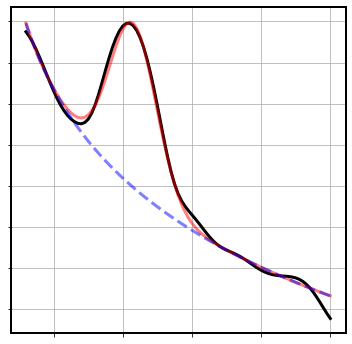

In [69]:
# Create the model fit plot
fig, ax = plt.subplots(figsize=[6, 6])
pfm.plot(ax=ax, plot_style=plot_style)

if SAVE_FIG:
    fig.savefig('../figures/task_PSD6.pdf')